# HTRU2 Clustering
นายชวศิษฐ์ เต็งไตรรัตน์ 580610631

interactive version: https://github.com/chawasit/DataMiningExercise

## References
- [How to select a clustering method?](https://stats.stackexchange.com/questions/195456/how-to-select-a-clustering-method-how-to-validate-a-cluster-solution-to-warran)
- [What is a good way to choose initial points of k clusters in k-means clustering?](https://www.quora.com/What-is-a-good-way-to-choose-initial-points-of-k-clusters-in-k-means-clustering)
- [Robust seed selection algorithm for k-means type algorithms (2012)](https://arxiv.org/abs/1202.1585)
- [Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)

## Import Tools

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

import matplotlib
# set defualt  size for plotting
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import dataset
dataset.prepare_dataset('data')

File exist! skip download
Files already extracted


## Data Analysis

                 a1            a2            a3            a4            a5  \
count  17898.000000  17898.000000  17898.000000  17898.000000  17898.000000   
mean     111.079968     46.549532      0.477857      1.770279     12.614400   
std       25.652935      6.843189      1.064040      6.167913     29.472897   
min        5.812500     24.772042     -1.876011     -1.791886      0.213211   
25%      100.929688     42.376018      0.027098     -0.188572      1.923077   
50%      115.078125     46.947479      0.223240      0.198710      2.801839   
75%      127.085938     51.023202      0.473325      0.927783      5.464256   
max      192.617188     98.778911      8.069522     68.101622    223.392140   

                 a6            a7            a8         label  
count  17898.000000  17898.000000  17898.000000  17898.000000  
mean      26.326515      8.303556    104.857709      0.091574  
std       19.470572      4.506092    106.514540      0.288432  
min        7.370432     -3.13927

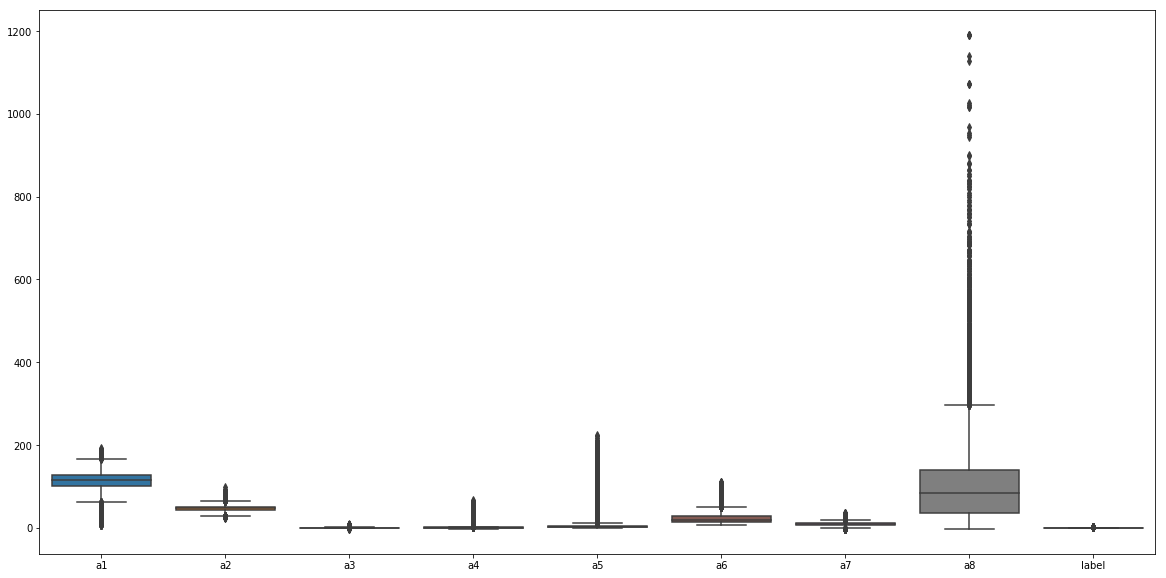

In [4]:
df = pd.read_csv('data/HTRU_2.csv', header=None, names=['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'label'])
df_wo_class = df.drop(columns=['label'])

print(df.describe())
sns.boxplot(data=df)

## Scaling Tools

จากรูปแบบการกระจายตัวของข้อมูลข้างต้น จะเห็นว่ามี 1 attribute ที่มีค่ากระโดดมาก คือ a8 ซึ่งต้องใช้ log scale ช่วยในการลดขนาดลงมาและยังคงไว้ซึ่งความหมายเดิม
ใน attributes อื่น ๆ จะเห็นว่าค่าไม่ได้กระโดดมาก และเป็นตัวเลขทั้งหมด จึงใช้ Standard Scale ข้อมูลให้อยู่มาตราฐานเดียวกัน

ดังนั้นจึงมี Scaler 2 ประเภท คือ
- StandardScaler
- AbsoluteLogScaler

In [5]:
class StandardScaler(object):
    def fit(self, X):
        self.mean = X.mean()
        size = X.shape[0]
        self.mean_absolute_deviation = np.abs(X - self.mean).sum() / size
        return self
    
    def transform(self, X):
        return (X - self.mean) / self.mean_absolute_deviation

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

class AbsoluteLogScaler(object):
    def fit(self, X):
        return self
        
    def transform(self, X):
        def abs_log(value):
            return np.log2(value) if value >= 0 else -np.log2(-value)
        
        return X * 3

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

### Data Processor Tool

เพื่อความสะดวกในการใช้งานจึงสร้าง class ที่กำหนดรูปแบบการ process ข้อมูลไว้แล้ว ตามการวิเคราะห์ข้างต้น

In [6]:
class DataProcessor(object):
    def fit(self, dataframe):
        self.a1 = StandardScaler().fit(dataframe.a1)
        self.a2 = StandardScaler().fit(dataframe.a2)
        self.a3 = StandardScaler().fit(dataframe.a3)
        self.a4 = StandardScaler().fit(dataframe.a4)
        self.a5 = StandardScaler().fit(dataframe.a5)
        self.a6 = StandardScaler().fit(dataframe.a6)
        self.a7 = StandardScaler().fit(dataframe.a7)
        self.a8_1 = AbsoluteLogScaler().fit(dataframe.a8)
        self.a8_2 = StandardScaler().fit(self.a8_1.transform(dataframe.a8))
        
    def transform(self, dataframe):
        dataframe = dataframe.copy()
        
        dataframe.a1 = self.a1.transform(dataframe.a1)
        dataframe.a2 = self.a2.transform(dataframe.a2)
        dataframe.a3 = self.a3.transform(dataframe.a3)
        dataframe.a4 = self.a4.transform(dataframe.a4)
        dataframe.a5 = self.a5.transform(dataframe.a5)
        dataframe.a6 = self.a6.transform(dataframe.a6)
        dataframe.a7 = self.a7.transform(dataframe.a7)
        dataframe.a8 = self.a8_2.transform(self.a8_1.transform(dataframe.a8))
        
        return dataframe
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

## Pre process
ทำการทดสอบ pre process ข้อมูล

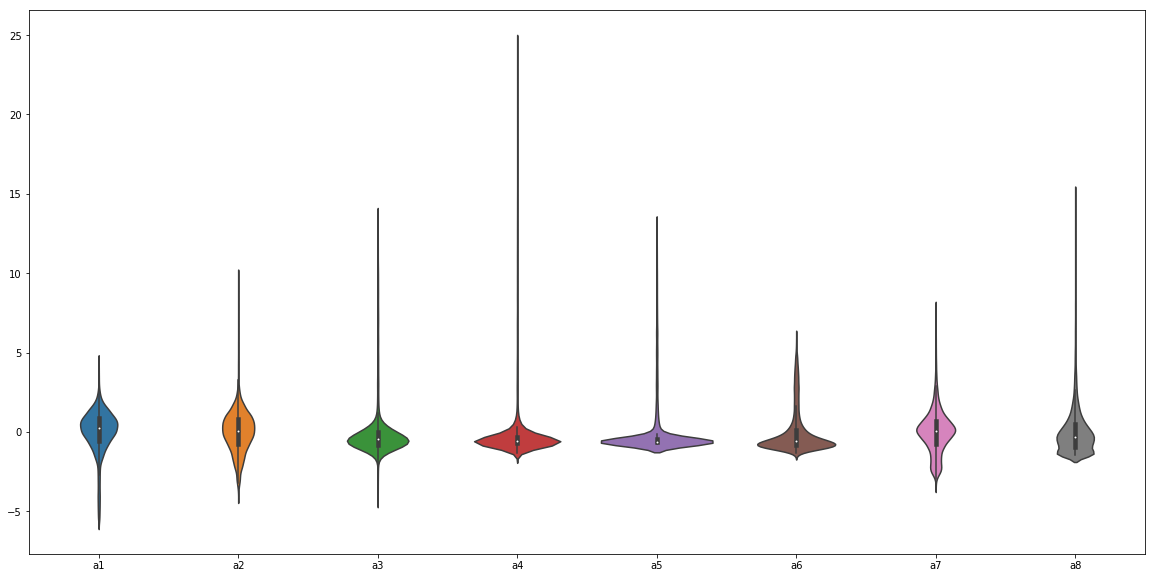

In [7]:
p = DataProcessor()
df_clean = p.fit_transform(df)
df_clean = df_clean.drop(columns=['label'])
sns.violinplot(data=df_clean)

### Attributes Correlation

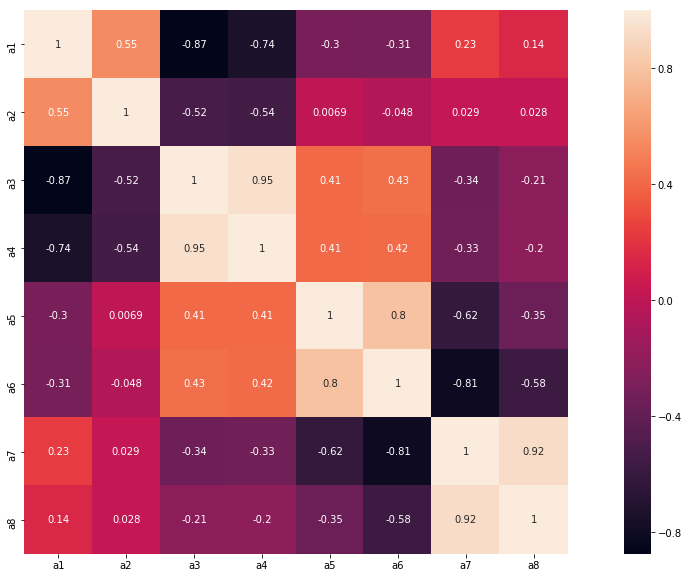

In [8]:
corelation = df_clean.corr()
sns.heatmap(corelation, square=True, annot=True)

### Clustering Tools

ในส่วนนี้จะเป็น class สำหรับการทำ clustering ประกอบไปด้วย 2 ส่วนคือ ส่วนสร้าง cluster (fit) และส่วนทำนายผล (predict)
Algorithm ที่เลือกใช้คือ KMean เนื่องจากชุดข้อมูลเป็น numeric ทั้งหมด สามารถหา mean ของข้อมูลได้ และเพื่อให้แต่ละครั้งในการทดลองให้ผลลัพท์ที่คงที่ที่สุดจึงใช้ Single Pass Seed Selection เข้ามาช่วยในการกำหนด centroids ของ cluster เริ่มต้น

ในการ update cluster จะเป็นแบบ batch คือทำการ assign cluster ใกล้เคียงก่อนจากนั้นจึง update centroid ของแต่ละ cluster 

ในการพัฒนาจะใช้ library ถายนอกช่วยในส่วนของการหา distance ที่มีความสามารถในการทำ parallel processing และ optimise มาดีแล้ว ร่วมกัน distance function ที่กำหนดขึ้นเอง เพื่อประสิทธิภาพในการประมวลผล
โดยเงื่อนไขในการหยุดทำงานจะมี 2 ส่วนคือ
1. ดำเนินการจนครบรอบที่กำหนดแล้ว (max iteration, default 300)
2. centroid ของ cluster ทั้งหมดมีการเปลี่ยนแปลงไม่เกินค่าที่กำหนด (tolerance, default 0.0001)

In [9]:
from sklearn.metrics.pairwise import pairwise_distances
from copy import deepcopy

def distance(n_root):
    def d(i, j):
        return  np.sum(np.abs(i - j) ** n_root) ** (1/n_root)
    
    return d


def euclidean():
    return distance(2)


class KMeanSPSS(object):
    def __init__(self
                 , n_cluster
                 , metric='euclidean'
                 , verbose=False
                 , max_iteration=300
                 , tolerance=1e-4
                 , n_jobs=1
                 , ):
        self.__dict__.update(locals())
        del self.self # We don't need this either
        
        self.labels = []
        self.cluster_centers = []
        self.sse = np.inf
        
        
    def _log(self, message):
        if self.verbose: print(message)
    
    
    def _distance(self, X, Y):
        return pairwise_distances(
            X=X
            , Y=Y
            , metric=self.metric
            , n_jobs=self.n_jobs)
    
    
    def _distance_to_nearest_centoid(self, data):
        distances = self._distance(data, self.cluster_centers)
        
        return distances.min(axis=1)
    
    
    def _nearest_centoid(self, data):
        distances = self._distance(data, self.cluster_centers)

        return distances.argmin(axis=1)
    
    def _sum_square_error(self, data):
        return np.sum(self._distance_to_nearest_centoid(data) ** 2)
            
    
    def _init_clusters(self, data):
        self._log("init clusters")
        m = data.shape[0]
        average_cluster_size = int(m / self.n_cluster)
        
        # step 1 calculate distance matrix
        dissimilarity = pairwise_distances(
            data
            , n_jobs=self.n_jobs
            , metric=self.metric)
        
        # step 2 find sumv which sumv(i) in the sum of the distances 
        # from Xi point to all other points
        sumv = dissimilarity.sum(axis=0)
        
        # step 3 find index h of minimim value of sumv
        h_index = np.unravel_index(sumv.argmin(), sumv.shape)[0]
        x_h = data[h_index]
        
        # step 4 Add Xh as the first centroid
        self._log(f" - First cluster center:{x_h}")
        self.cluster_centers = [x_h]
        
        selected_index = set([h_index])
        
        while len(self.cluster_centers) < self.n_cluster:
            # step 5 calculate d(Xi) which is distance 
            # between Xi and nearest centroid
            d = self._distance_to_nearest_centoid(data)
            d2 = d ** 2
            self._log(f" - distance to nearest controid: {d}")

            # step 6 find y as th e sum of distances of 
            # first m/k nearest points from Xh
            distance_from_xh = dissimilarity[h_index]
            sorted_distance = np.sort(distance_from_xh)
            y = np.sum(sorted_distance[:average_cluster_size])
            self._log(f" - y = {y}")

            # step 7-8 find i that satisfy 
            # d(X1)2+d(X2)2+...+d(Xi)2> = y>d(X1)2+d(X2)2+...+d(X(i-1))2
            select_i = -1
            self._log(f" - Sum d = {np.sum(d ** 2)}")
            for i in range(m):
                if np.sum(d2[:i]) >= y and y > np.sum(d2[:i-1]) and i not in selected_index:
                    select_i = i
                    selected_index.add(i)
                    break
                    
            if select_i == -1:
                raise Exception("Can't init cluster")
                
            self._log(f" - Next cluster index: {select_i}")

            # step 9 add Xi as new centroid
            self.cluster_centers += [data[select_i]]
        
        self.cluster_centers = np.array(self.cluster_centers)
        self._log(f"end init clusters: {self.cluster_centers}")
    
    
    def _update_cost(self, old_cluster_centers, new_cluster_centers):
        costs = self._distance(old_cluster_centers, new_cluster_centers)
        costs = np.array([costs[i, i] for i in range(self.n_cluster)])
        
        return costs

    
    def _update_cluster_centers(self, data, new_labels):
        old_cluster_centers = deepcopy(self.cluster_centers)
        
        new_cluster_centers = []
        for label in range(self.n_cluster):
            members = data[new_labels == label]
            new_cluster_centers += [members.mean(axis=0)]
        
        self.cluster_centers = np.array(new_cluster_centers)
        self.labels = self._nearest_centoid(data)
        
        costs = self._update_cost(old_cluster_centers, new_cluster_centers)
        self._log(f" - update costs: {costs}")
        
        is_optimal = not np.any(costs > self.tolerance)
        self._log(f" - optimal: {is_optimal}")
        
        return is_optimal
    
        
    def fit(self, data):
        self.labels = []
        self.cluster_centers = []
        
        # convert pandas DataFrame to numpy ndarray
        # for better performance
        if type(data) is pd.DataFrame:
            data = data.as_matrix()
            
        self._init_clusters(data)
        
        # start clustering
        for it in range(self.max_iteration):
            self._log(f"iteration {it:4}")
            local_labels = self._nearest_centoid(data)
            is_optimal = self._update_cluster_centers(data, local_labels)
            
            if is_optimal:
                break
                
        self.sse = self._sum_square_error(data)
                
        return self
    
    
    def predict(self, data):
        return self._nearest_centoid(data)
    
    
cluster = KMeanSPSS(n_cluster=2, metric='cosine', verbose=True).fit(df_clean)

init clusters
 - First cluster center:[ 0.16954884  0.06491949 -0.47717165 -0.65346259 -0.63931725 -0.55713695
  0.28386431 -0.14565274]
 - distance to nearest controid: [0.37450423 0.52135904 0.65467247 ... 1.1540801  0.29381317 1.54311412]
 - y = 2741.6835900117703
 - Sum d = 12102.773913390873
 - Next cluster index: 3887
end init clusters: [[ 0.16954884  0.06491949 -0.47717165 -0.65346259 -0.63931725 -0.55713695
   0.28386431 -0.14565274]
 [ 1.50760879  1.1450391  -1.20256455 -0.73772123 -0.47206094  0.08664838
  -0.60050287 -0.87253438]]
iteration    0
 - update costs: [0.30345047 0.86258315]
 - optimal: False
iteration    1
 - update costs: [0.04026797 0.04026797]
 - optimal: False
iteration    2
 - update costs: [0.00852623 0.00852623]
 - optimal: False
iteration    3
 - update costs: [0.00183995 0.00183995]
 - optimal: False
iteration    4
 - update costs: [0.00041186 0.00041186]
 - optimal: False
iteration    5
 - update costs: [7.88226269e-05 7.88226269e-05]
 - optimal: True


### Plot Tool

เป็น function สำหรับสร้างกราฟ 3 มิติเพื่อ visualize cluster โดยจะใช้ Principal component analysis ในการลดมิติให้เหลือ 3 มิติ จากนั้นจะทำการ plot ตาม label ของข้อมูล

In [10]:
from sklearn.decomposition import PCA

def plot3d(dataframe, labels, name):
    unique_labels = np.unique(labels)
    
    pca = PCA(n_components=3)
    df_reduced = pca.fit_transform(df_clean)
    
    plot_datas = []
    for label in unique_labels:
        local_data = df_reduced[labels==label]

        plot_datas += [go.Scatter3d(
            x=local_data[:,0],
            y=local_data[:,1],
            z=local_data[:,2],
            mode='markers',
            marker=dict(
                size=6,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.05
                ),
                opacity=0.5
            )
        )]

    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    
    fig = go.Figure(data=plot_datas, layout=layout)
    return py.iplot(fig, filename=name)

## Distance Function

ส่วนนี้จะทำการทดลองหา distance function ที่หมาะสมจาก 3 ตัว คือ manhattan, euclidean และ cosine โดยเปรียบเทียบกับ labels ตั้งแต่ขอชุดข้อมูล

### Visualized Dataset

In [11]:
plot3d(df_clean, df['label'], 'HTRU2-dataset-label')

### Euclidean Distance

In [12]:
cluster = KMeanSPSS(n_cluster=2, metric='euclidean').fit(df_clean)
print(cluster.cluster_centers, cluster.sse)
plot3d(df_clean, cluster.labels, 'HTRU2-k2-euclidean')

[[-4.10820044 -2.27936207  7.08606037  8.31336964  3.43880701  2.67675377
  -2.05069069 -1.40252067]
 [ 0.22951247  0.12734092 -0.3958763  -0.46444228 -0.19211552 -0.14954196
   0.11456575  0.0783545 ]] 220087.61926540302


### Manhattan Distance

In [13]:
cluster = KMeanSPSS(n_cluster=2, metric='manhattan').fit(df_clean)
print(cluster.cluster_centers, cluster.sse)
plot3d(df_clean, cluster.labels, 'HTRU2-k2-manhattan')

[[ 0.2569698   0.13692394 -0.43054671 -0.48780731 -0.21463    -0.17772481
   0.13502955  0.09339413]
 [-3.84949937 -2.05116959  6.44974351  7.30752772  3.21523411  2.66238107
  -2.02279082 -1.39907748]] 1003412.8312470393


### Cosine Distance

In [15]:
cluster = KMeanSPSS(n_cluster=2, metric='cosine').fit(df_clean)
print(cluster.cluster_centers, cluster.sse)
plot3d(df_clean, cluster.labels, 'HTRU2-k2-cosine')

[[ 0.3859462   0.20044594 -0.53091417 -0.55674614 -0.62333396 -0.6493187
   0.57184065  0.46086291]
 [-0.96479004 -0.50107566  1.3271816   1.39175648  1.558213    1.62316979
  -1.42948981 -1.15206714]] 4844.825760316067


### result

จาการทดลองจะเห็นว่า Manhattan และ Euclidean ให้ผลลัพธ์ใกล้เคียงกับชุดข้อมูลจริงมากที่สุด โดนผลของ manhattan จะให้ True Positive มากกว่า euclidean แต่มีข้อมูลส่วนน้อยที่เป็น outlier ที่ทับซ้อนกันอยู่ในทั้ง 2 labels นั้นไม่สามารถแยกได้โดยการทำ clustering 


## Clustering with K greater than 2

การทดลองนี้จะทำการเพิ่ม K เพื่อดูว่าชุดข้อมูลจะถูก cluster ออกมาในรูปแบบไหน โดยจะใช้ distance function เป็น Manhattan

In [16]:
cluster = KMeanSPSS(n_cluster=3, metric='manhattan').fit(df_clean)
print(cluster.cluster_centers, cluster.sse)
plot3d(df_clean, cluster.labels, 'HTRU2-k3-manhattan')

[[-4.07541382 -2.32445169  7.04835911  8.28023728  3.20600819  2.59721524
  -2.01506068 -1.39724766]
 [ 0.23154045  0.0529581  -0.42304909 -0.47938996 -0.58856519 -0.51869223
   0.37586018  0.25451636]
 [ 0.22378548  0.80470296 -0.19356141 -0.37801352  3.30259955  3.03401561
  -2.1265396  -1.42228502]] 682143.8290669571


In [17]:
cluster = KMeanSPSS(n_cluster=4, metric='manhattan').fit(df_clean)
print(cluster.cluster_centers, cluster.sse)
plot3d(df_clean, cluster.labels, 'HTRU2-k4-manhattan')

Exception: Can't init cluster

### result

จาการทดลองนี้ไม่สามารถแบ่ง cluster มากกว่า 3 ได้โดยที่ใช้ Manhattan เป็น distance function ซึ่งเป็นผลมาจาก SPSS มีสมมติฐานว่าข้อมูลนั้นเป็น uniform จะสามารถแบ่งออกเป็น k ส่วนเท่า ๆ กันได้ แต่ชุดข้อมูลนี้ไม่สามารถแบ่งข้อมูลออกเป็น k ส่วนที่มี density เท่า ๆ กันได้ด้วย Manhattan Distance นั่นเอง

## ทดสอบค่า k ที่สามารถใช้สร้าง cluster ด้วย distance ต่าง ๆ

จะทำการทดสอบ 3 distance function เช่นเดิม และค่า k เริ่มต้นที่ 2 ถึง 10

In [18]:
for metric in ['manhattan', 'euclidean', 'cosine']:
    for k in range(2, 11):
        try:
            cluster = KMeanSPSS(n_cluster=k, metric=metric, verbose=False).fit(df_clean)
            print(f"Distance function: {metric}, K={k}, sum square error={cluster.sse}")
        except:
            break

Distance function: manhattan, K=2, sum square error=1003412.8312470393
Distance function: manhattan, K=3, sum square error=682143.8290669571
Distance function: euclidean, K=2, sum square error=220087.61926540302
Distance function: euclidean, K=3, sum square error=159566.9689922513
Distance function: euclidean, K=4, sum square error=127835.46087666905
Distance function: cosine, K=2, sum square error=4844.825760316067
Distance function: cosine, K=3, sum square error=2383.8992873070306
Distance function: cosine, K=4, sum square error=1751.6816120916085
Distance function: cosine, K=5, sum square error=995.3121925334616
Distance function: cosine, K=6, sum square error=766.5908177622072
Distance function: cosine, K=7, sum square error=677.6985004995548
Distance function: cosine, K=8, sum square error=515.2669689656245
Distance function: cosine, K=9, sum square error=422.7136707214079
Distance function: cosine, K=10, sum square error=405.92553709044205


### result

จะเห็นว่า cosine นั้นสามารถสร้างได้ถึง 10 อย่างไม่มีปัญหา จากการวิเคราะห์ sum square error ค่า K ที่เหมาะสมสำหรับ cosine distance คือ 5 เนื่องจากเป้นจุดที่การเปลี่ยนแปลงของ error เริ่มน้อยลงอย่างเห็นได้ชัด
และ k = 4 สำหรับ euclidean

## Visualized Cosine Distance with K5

In [19]:
cluster = KMeanSPSS(n_cluster=5, metric='cosine').fit(df_clean)
print(cluster.cluster_centers, cluster.sse)
plot3d(df_clean, cluster.labels, 'HTRU2-k5-cosine')

[[-0.70691759 -1.184249    0.05662625 -0.09529819 -0.5954415  -0.5126409
   0.0952673  -0.18918871]
 [ 0.43926399  0.74549912 -0.51401031 -0.58616794  2.528359    2.49962421
  -1.90244708 -1.36488394]
 [ 0.22713814  0.09286815 -0.44346529 -0.53826692 -0.69125925 -0.95282743
   1.55677928  1.76777192]
 [ 0.79004638  0.69260631 -0.73958555 -0.6859731  -0.55764447 -0.37195568
  -0.13282905 -0.41614715]
 [-3.41171708 -1.87685926  5.5122356   6.03701551  2.3762555   2.2212216
  -1.79125763 -1.32335168]] 995.3121925334616


## Visualized Euclidean Distance with K4

In [20]:
cluster = KMeanSPSS(n_cluster=4, metric='euclidean').fit(df_clean)
print(cluster.cluster_centers, cluster.sse)
plot3d(df_clean, cluster.labels, 'HTRU2-k4-euclidean')

[[ 0.17876449  0.97060916 -0.11017991 -0.30799029  5.09865455  3.69179865
  -2.41267117 -1.45782599]
 [ 0.15569894 -0.02767349 -0.40717838 -0.46918933 -0.70473631 -1.0134915
   1.92002164  2.31218255]
 [ 0.23226182  0.08628805 -0.3914853  -0.45779903 -0.49619366 -0.24366089
  -0.1514154  -0.38376365]
 [-4.20504722 -2.40462098  7.39557354  8.85350582  3.31654067  2.65099245
  -2.04103815 -1.40374925]] 127835.46087666905


### เทียบกับ Dataset Label อีกครั้ง

In [21]:
plot3d(df_clean, df['label'], 'HTRU2-dataset-label')

## Conclusion

หากการทดลองนี้ตั้งเป้าหมายการใช้งานเป็น "ต้องการให้ผลใกล้เคียงกับ dataset label มากที่สุด" จะได้ผลว่า cosine distance และ k=5 ให้ผลลัพธ์ดีที่สุด และในส่วนของ cluster ที่แบ่ง label negative ออกเป็น 4 ส่วนนั้นอาจะจะมีความหมายของมันอยู่ ซึ่งสามารถวิเคราะห์ต่อไปได้
